In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np

from PIL import Image
import os
import PIL
import PIL.Image
import sys
import glob
from pathlib import Path


# Get the path of the dataset
os.chdir(sys.path[0])
working_directory = os.getcwd()
print(working_directory)
data_path = Path(working_directory + r"/dataset/IMG_CLASSES")

# Count the number of images within the  dataset
image_count = len(list(data_path.glob('*/*.jpg')))
print("The number of images in the dataset is " + str(image_count))

# Batch size and dimensions
batch_size = 30
IMG_SIZE = (200,200)

#Assigning the data splits and seed
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_path,
    validation_split=0.2,
    subset='training',
    seed=123,
    image_size=IMG_SIZE,
    batch_size=batch_size
)

validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_path,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=batch_size
)

d:\VIP_Project
The number of images in the dataset is 27153
Found 27153 files belonging to 10 classes.
Using 21723 files for training.
Found 27153 files belonging to 10 classes.
Using 5430 files for validation.


In [2]:
data_augmentation = keras.Sequential([
    layers.RandomRotation(factor=0.15),
    layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
    layers.RandomFlip(),
    layers.RandomContrast(factor=0.1),
])

In [3]:
preprocess_input = tf.keras.applications.resnet.preprocess_input

In [4]:
IMG_SIZE = (200,200)
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.resnet.ResNet50(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet',
                                               classes=10
                                              )

#freeze all the layer
for layer in base_model.layers:
    layer.trainable = False

In [5]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 200, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 206, 206, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 100, 100, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [6]:
inputs = tf.keras.Input(shape=(200,200, 3))

x = preprocess_input(inputs)
x = data_augmentation(x)
x = base_model(x, training=False)

# Flatten the output layer to 1 dimension
x = layers.GlobalAveragePooling2D()(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x) 
x = layers.Dense(512, activation ='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)

predictions = layers.Dense(10, activation='softmax')(x)

# Configure and compile the model

model = keras.Model(inputs, predictions)
model.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=['accuracy'])

In [7]:
history = model.fit(train_dataset,
                    epochs=5,
                    validation_data=validation_dataset,
                    batch_size = 64
                   )

Epoch 1/5
725/725 [==============================] - 92s 118ms/step - loss: 1.3919 - accuracy: 0.5497 - val_loss: 0.9126 - val_accuracy: 0.6613
Epoch 2/5
725/725 [==============================] - 87s 120ms/step - loss: 1.0326 - accuracy: 0.6162 - val_loss: 0.8507 - val_accuracy: 0.6783
Epoch 3/5
725/725 [==============================] - 90s 123ms/step - loss: 0.9809 - accuracy: 0.6305 - val_loss: 0.8280 - val_accuracy: 0.6842
Epoch 4/5
725/725 [==============================] - 89s 123ms/step - loss: 0.9370 - accuracy: 0.6472 - val_loss: 0.8041 - val_accuracy: 0.6864
Epoch 5/5
725/725 [==============================] - 89s 123ms/step - loss: 0.9196 - accuracy: 0.6522 - val_loss: 0.8407 - val_accuracy: 0.6796


In [8]:
for layer in base_model.layers[-30:]:
    if not isinstance(layer, layers.BatchNormalization):
        layer.trainable = True

    
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=['accuracy'])

In [9]:
learning_rate_reduction = keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', patience=3, verbose=1, factor=0.5, 
                                            min_lr=0.000001, cooldown=2)

In [10]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 200, 200, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 200, 200, 3)      0         
                                                                 
 sequential (Sequential)     (None, 200, 200, 3)       0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                      

In [11]:
history_unfreeze = model.fit(train_dataset,
                    epochs=30,
                    validation_data=validation_dataset,
                    callbacks = [learning_rate_reduction]
)

Epoch 1/30
725/725 [==============================] - 106s 140ms/step - loss: 0.8755 - accuracy: 0.6726 - val_loss: 0.7475 - val_accuracy: 0.7204 - lr: 1.0000e-04
Epoch 2/30
725/725 [==============================] - 101s 139ms/step - loss: 0.7915 - accuracy: 0.7030 - val_loss: 0.7034 - val_accuracy: 0.7335 - lr: 1.0000e-04
Epoch 3/30
725/725 [==============================] - 101s 139ms/step - loss: 0.7381 - accuracy: 0.7244 - val_loss: 0.7094 - val_accuracy: 0.7387 - lr: 1.0000e-04
Epoch 4/30
725/725 [==============================] - 101s 139ms/step - loss: 0.7071 - accuracy: 0.7352 - val_loss: 0.6449 - val_accuracy: 0.7619 - lr: 1.0000e-04
Epoch 5/30
725/725 [==============================] - 101s 139ms/step - loss: 0.6708 - accuracy: 0.7488 - val_loss: 0.6771 - val_accuracy: 0.7444 - lr: 1.0000e-04
Epoch 6/30
725/725 [==============================] - 101s 139ms/step - loss: 0.6540 - accuracy: 0.7564 - val_loss: 0.6265 - val_accuracy: 0.7700 - lr: 1.0000e-04
Epoch 7/30
725/725 [==

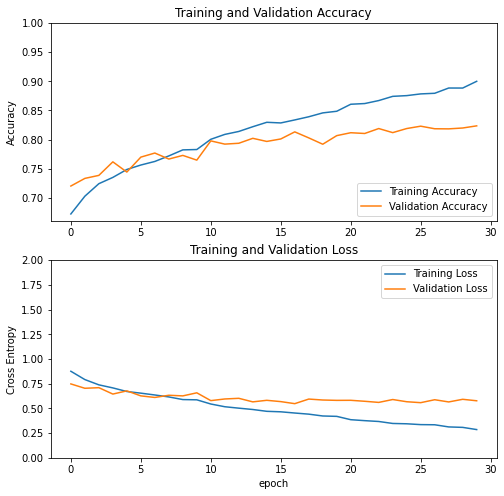

C:\Users\user\anaconda3\envs\tf\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [16]:
acc = history_unfreeze.history['accuracy']
val_acc = history_unfreeze.history['val_accuracy']

loss = history_unfreeze.history['loss']
val_loss = history_unfreeze.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,2.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.savefig('resnet50 score.png')
plt.show()

model.save("resnet50.h5")

In [17]:
import pandas as pd
# convert the history.history dict to a pandas DataFrame:     
hist_df = pd.DataFrame(history_unfreeze.history) 

# save to json:  
hist_json_file = 'resnet_finetune_history.json' 
with open(hist_json_file, mode='w') as f:
    hist_df.to_json(f)
    
hist_csv_file = 'resnet_finetune_history.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

        loss  accuracy  val_loss  val_accuracy        lr
0   0.875510  0.672559  0.747464      0.720442  0.000100
1   0.791517  0.702988  0.703394      0.733517  0.000100
2   0.738146  0.724440  0.709429      0.738674  0.000100
3   0.707123  0.735212  0.644862      0.761878  0.000100
4   0.670762  0.748792  0.677085      0.744383  0.000100
5   0.654008  0.756433  0.626538      0.769982  0.000100
6   0.635607  0.762556  0.610550      0.776980  0.000100
7   0.615759  0.772039  0.632813      0.766667  0.000100
8   0.589184  0.782397  0.626376      0.772928  0.000100
9   0.586641  0.782995  0.657493      0.764825  0.000100
10  0.544257  0.800534  0.578551      0.797790  0.000050
11  0.516666  0.808912  0.595183      0.792265  0.000050
12  0.502211  0.813976  0.601867      0.793738  0.000050
13  0.488676  0.822078  0.565929      0.802210  0.000050
14  0.470320  0.829674  0.581672      0.796869  0.000050
15  0.465375  0.828569  0.568495      0.801105  0.000050
16  0.453025  0.833725  0.54780